# Загрузка датасета

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [31]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [32]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [33]:
y_test = data.iloc[-24*7:]['Usage_kWh'].values

In [34]:
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [36]:
df_results = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions = pd.DataFrame(None)
df_predictions['True'] = y_test

In [37]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def r2(y_true, y_pred):
    ssres = sum((y_true-y_pred)**2)
    sstotal = sum((y_true-np.mean(y_true))**2)
    return 1 - ssres/sstotal

In [38]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])

# DecisionTree

In [39]:
model = DecisionTreeRegressor()
parameters = {'max_depth' : list(range(1, 21))}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

In [42]:
model_name = 'DecisionTree'
params = {'max_depth': gridsearch.best_params_['max_depth']}
Tuner = True
params

{'max_depth': 7}

In [44]:
model = DecisionTreeRegressor(max_depth=params['max_depth'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [45]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [46]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':end_tuner-start_tuner,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.20601


In [47]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

In [48]:
model = DecisionTreeRegressor()
parameters = {'max_depth' : list(range(1, 21))}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

model_name = 'DecisionTree'
params = {'max_depth': gridsearch.best_params_['max_depth']}
Tuner = True
params

{'max_depth': 8}

In [49]:
model = DecisionTreeRegressor(max_depth=params['max_depth'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [50]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [51]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.20601
1,DecisionTree(Сутки за раз),True,{'max_depth': 8},10.552595,16959.824443,93.688000,0.853908,19.740879,None,0.00800


In [52]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])

In [54]:
model = DecisionTreeRegressor()
parameters = {'max_depth' : list(range(1, 21))}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

model_name = 'DecisionTree'
params = {'max_depth': gridsearch.best_params_['max_depth']}
Tuner = True
params

{'max_depth': 8}

In [55]:
model = DecisionTreeRegressor(max_depth=params['max_depth'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [56]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [57]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.206010
1,DecisionTree(Сутки за раз),True,{'max_depth': 8},10.552595,16959.824443,93.688000,0.853908,19.740879,None,0.008000
2,DecisionTree(Неделя за раз),True,{'max_depth': 8},9.273271,11527.566307,82.471311,0.900702,58.040292,None,0.002001


In [58]:
dates_list = []
for d in data[-24*7:]['Date']:
    if d not in dates_list:
        dates_list.append(d)

In [59]:
dates_list

[Timestamp('2020-12-25 00:00:00'),
 Timestamp('2020-12-26 00:00:00'),
 Timestamp('2020-12-27 00:00:00'),
 Timestamp('2020-12-28 00:00:00'),
 Timestamp('2020-12-29 00:00:00'),
 Timestamp('2020-12-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00')]

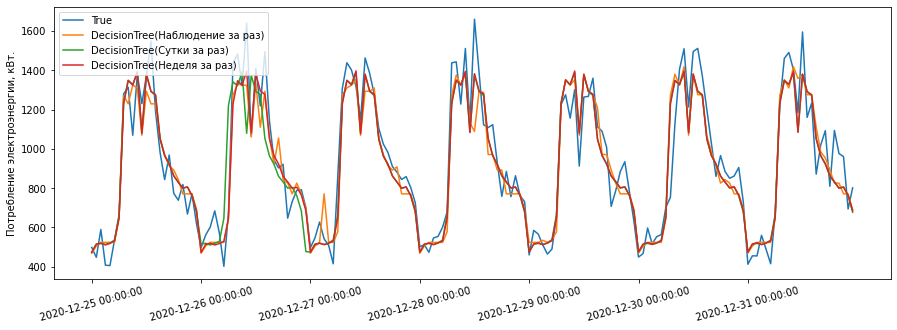

In [60]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [61]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

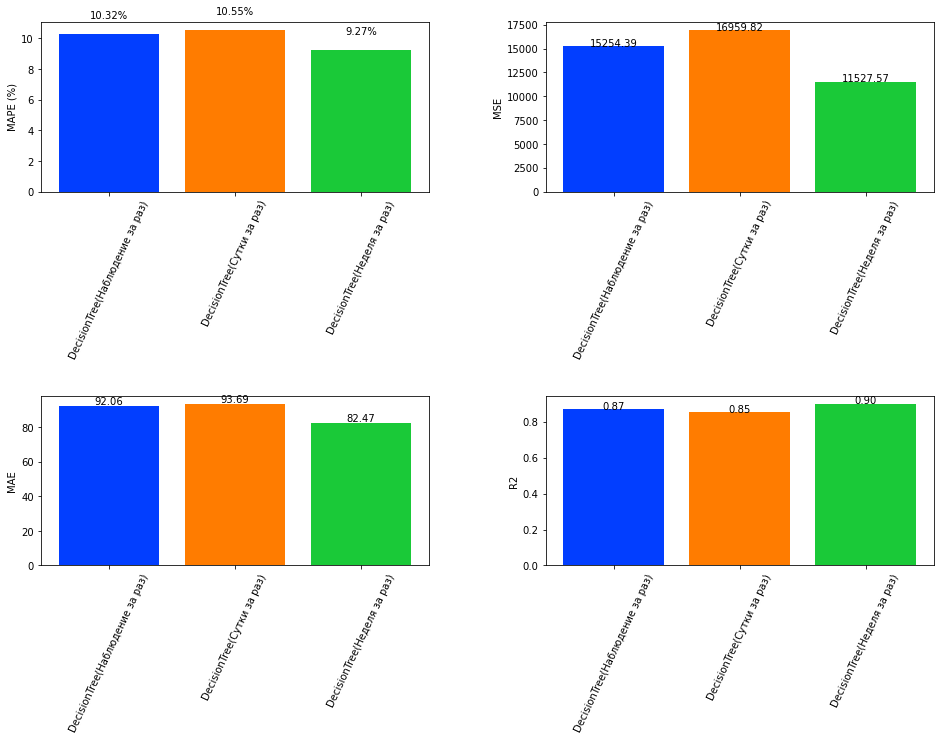

In [62]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Random Forest

In [64]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = 'RandomForest'
Tuner = True


model = RandomForestRegressor()
parameters = {'n_estimators' : list(range(10, 151, 10))}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

params = {'n_estimators': gridsearch.best_params_['n_estimators']}


model = RandomForestRegressor(n_estimators=params['n_estimators'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.206010
1,DecisionTree(Сутки за раз),True,{'max_depth': 8},10.552595,16959.824443,93.688000,0.853908,19.740879,None,0.008000
2,DecisionTree(Неделя за раз),True,{'max_depth': 8},9.273271,11527.566307,82.471311,0.900702,58.040292,None,0.002001
3,RandomForest(Наблюдение за раз),True,{'n_estimators': 150},9.312250,12257.438720,82.477158,0.894414,887.436490,None,2.132349


In [66]:
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [68]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = 'RandomForest'
Tuner = True


model = RandomForestRegressor()
parameters = {'n_estimators' : list(range(10, 151, 10))}
gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
start_tuner = time.time()
gridsearch.fit(X_train, y_train)
end_tuner = time.time()

params = {'n_estimators': gridsearch.best_params_['n_estimators']}


model = RandomForestRegressor(n_estimators=params['n_estimators'])
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.206010
1,DecisionTree(Сутки за раз),True,{'max_depth': 8},10.552595,16959.824443,93.688000,0.853908,19.740879,None,0.008000
2,DecisionTree(Неделя за раз),True,{'max_depth': 8},9.273271,11527.566307,82.471311,0.900702,58.040292,None,0.002001
3,RandomForest(Наблюдение за раз),True,{'n_estimators': 150},9.312250,12257.438720,82.477158,0.894414,887.436490,None,2.132349
4,RandomForest(Сутки за раз),True,{'n_estimators': 110},10.755710,17896.516883,99.554433,0.845839,1435.127419,None,0.200606


In [76]:
df_results

,Model,Tuner,Params,MAPE,MSE,MAE,R2,Training_time,Tuner_time,Time_prediction
0,DecisionTree(Наблюдение за раз),True,{'max_depth': 7},10.319345,15254.388766,92.061003,0.868599,5.335809,447.066828,0.206010
1,DecisionTree(Сутки за раз),True,{'max_depth': 8},10.552595,16959.824443,93.688000,0.853908,19.740879,None,0.008000
2,RandomForest(Наблюдение за раз),True,{'n_estimators': 150},9.312250,12257.438720,82.477158,0.894414,887.436490,None,2.132349
3,RandomForest(Сутки за раз),True,{'n_estimators': 110},10.755710,17896.516883,99.554433,0.845839,1435.127419,None,0.200606


In [70]:
# WINDOW = 24*7
# Forecast_type = 'Неделя за раз'

# X_train, y_train = [], []
# for i in range(0, len(y)-24*14):
#     X_train.append(y[i:i+WINDOW])
#     y_train.append(y[i+WINDOW:i+WINDOW+24*7])
    
# model_name = 'RandomForest'
# Tuner = True


# model = RandomForestRegressor()
# parameters = {'n_estimators' : list(range(10, 151, 10))}
# gridsearch = GridSearchCV(model, parameters, n_jobs=-1)
# start_tuner = time.time()
# gridsearch.fit(X_train, y_train)
# end_tuner = time.time()

# params = {'n_estimators': gridsearch.best_params_['n_estimators']}


# model = RandomForestRegressor(n_estimators=params['n_estimators'])
# start_training = time.time()
# model.fit(X_train, y_train)
# end_training = time.time()
    
# y_pred = []
# X_for_prediction = y[-24*7:]
# start_prediction = time.time()
# y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
# end_prediction = time.time()
# df_predictions[f'{model_name}({Forecast_type})'] = y_pred

# df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
#                         'Tuner':Tuner,
#                         'Params': params,
#                         'MAPE':mape(y_test, y_pred),
#                         'MSE':mse(y_test, y_pred),
#                         'MAE':mae(y_test, y_pred),
#                         'R2':r2(y_test, y_pred),
#                         #'Sum':sum(y_pred),
#                         'Training_time':end_training-start_training,
#                         'Tuner_time':None,
#                         'Time_prediction':end_prediction-start_prediction},
#                                                                 ignore_index=True)
# df_results

In [81]:
df_predictions = df_predictions.drop('DecisionTree(Неделя за раз)', axis=1)
df_predictions

,True,DecisionTree(Наблюдение за раз),DecisionTree(Сутки за раз),RandomForest(Наблюдение за раз),RandomForest(Сутки за раз)
0,498.574076,469.243397,474.983074,475.147589,514.362343
1,448.325927,505.898468,515.085091,510.974315,526.344557
2,589.959784,524.353136,519.212918,529.954377,549.574031
3,408.063429,524.353136,513.676200,515.862259,538.834932
4,406.263067,524.353136,520.784918,512.533463,532.291909
...,...,...,...,...,...
163,1093.896979,826.002374,829.916534,862.105341,830.044799
164,976.242006,826.002374,800.767000,820.092363,794.228230
165,960.551132,771.197829,805.631365,838.210333,818.087582
166,694.074945,771.197829,761.616545,776.327813,755.380552


In [82]:
# plt.figure(figsize=(15, 5))
# for col in df_predictions.columns:
#     plt.plot(df_predictions[col], label=col)
# plt.ylabel('Потребление электроэнергии, кВт.')
# plt.legend()
# plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [83]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

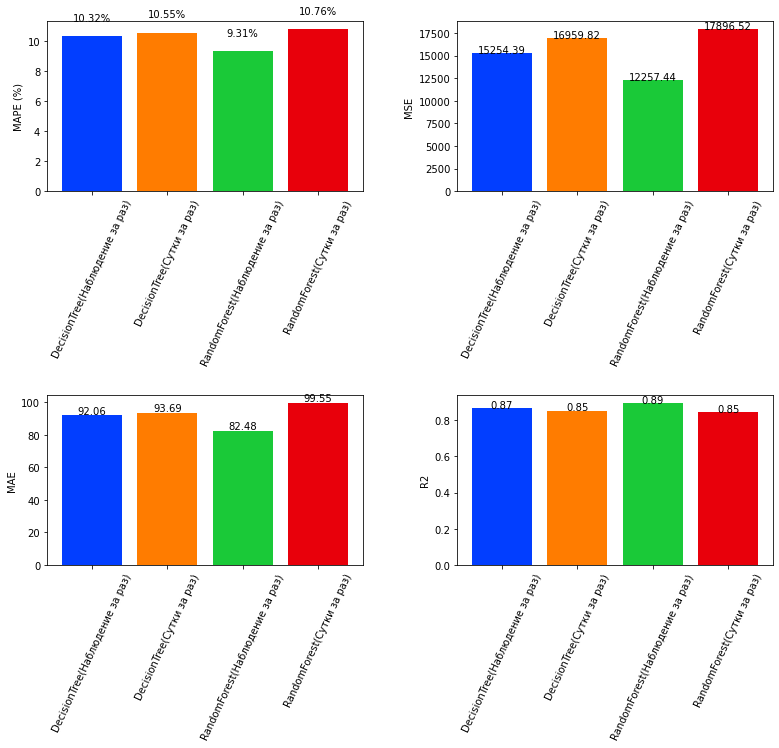

In [87]:
plt.figure(figsize=(13, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

In [88]:
df_results.to_csv('Trees_grid_results.csv')
df_predictions.to_csv('Trees_grid_predictions.csv')